# Setting Up

In [346]:
import pandas as pd
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import contractions
from nlppreprocess import NLP

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import NearMiss

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

In [323]:
# Read txt
df2016_train = pd.read_csv('datasets/twitter-2016train-A.txt', sep='\t', header=None, names=['id', 'sentiment', 'text'])
df2016_devtest = pd.read_csv('datasets/twitter-2016devtest-A.txt', sep='\t', header=None, names=['id', 'sentiment', 'text'])
df2016_dev = pd.read_csv('datasets/twitter-2016dev-A.txt', sep='\t', header=None, names=['id', 'sentiment', 'text'])
df2016_test = pd.read_csv('datasets/twitter-2013test-A.txt', sep='\t', header=None, names=['id', 'sentiment', 'text'])

df2015_train = pd.read_csv('datasets/twitter-2015train-A.txt', sep='\t', header=None, names=['id', 'sentiment', 'text'])
df2015_test = pd.read_csv('datasets/twitter-2015test-A.txt', sep='\t', header=None, names=['id', 'sentiment', 'text'])

df2014_sarcasm = pd.read_csv('datasets/twitter-2014sarcasm-A.txt', sep='\t', header=None, names=['id', 'sentiment', 'text'])
df2014_test = pd.read_csv('datasets/twitter-2014test-A.txt', sep='\t', header=None, names=['id', 'sentiment', 'text'])

df2013_train = pd.read_csv('datasets/twitter-2013train-A.txt', sep='\t', header=None, names=['id', 'sentiment', 'text'])
df2013_dev = pd.read_csv('datasets/twitter-2013dev-A.txt', sep='\t', header=None, names=['id', 'sentiment', 'text'])
df2013_test = pd.read_csv('datasets/twitter-2013test-A.txt', sep='\t', header=None, names=['id', 'sentiment', 'text'])

# Decode unicode characters (if any)
df2016_train['text'] = df2016_train['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))
#df2016_devtest['text'] = df2016_devtest['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))
df2016_dev['text'] = df2016_dev['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))
df2016_test['text'] = df2016_test['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))

df2015_train['text'] = df2015_train['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))
df2015_test['text'] = df2015_test['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))

df2014_sarcasm['text'] = df2014_sarcasm['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))
df2014_test['text'] = df2014_test['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))

df2013_train['text'] = df2013_train['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))
df2013_dev['text'] = df2013_dev['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))
df2013_test['text'] = df2013_test['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))

# Concat
#df = pd.concat([df2016_train, df2016_dev, df2016_test, df2016_devtest, df2015_train, df2015_test, df2014_sarcasm, df2014_test, df2013_train, df2013_dev, df2013_test], ignore_index=True, axis=0)
df = pd.concat([df2016_train, df2016_dev, df2016_test, df2016_devtest, df2015_train, df2015_test, df2014_test, df2013_train, df2013_dev, df2013_test], ignore_index=True, axis=0)
#df = pd.concat([df2016_train, df2016_dev, df2015_train, df2013_train, df2013_dev], ignore_index=True, axis=0)

# Drop id column
df.drop(columns=['id'], inplace=True)

df

C:\Users\EANG\AppData\Local\Temp\ipykernel_16512\2525603754.py:18: DeprecationWarning: invalid escape sequence '\m'
  df2016_train['text'] = df2016_train['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))
C:\Users\EANG\AppData\Local\Temp\ipykernel_16512\2525603754.py:21: DeprecationWarning: invalid escape sequence '\ '
  df2016_test['text'] = df2016_test['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))
C:\Users\EANG\AppData\Local\Temp\ipykernel_16512\2525603754.py:21: DeprecationWarning: invalid escape sequence '\i'
  df2016_test['text'] = df2016_test['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))
C:\Users\EANG\AppData\Local\Temp\ipykernel_16512\2525603754.py:21: DeprecationWarning: invalid escape sequence '\('
  df2016_test['text'] = df2016_test['text'].apply(lambda x: x.encode("utf-8").decode("unicode-escape"))
C:\Users\EANG\AppData\Local\Temp\ipykernel_16512\2525603754.py:21: DeprecationWarning: invalid escape sequence '\m'
  

,sentiment,text
0,negative,dear @Microsoft the newOoffice for Mac is grea...
1,negative,@Microsoft how about you make a system that do...
2,negative,I may be ignorant on this issue but... should ...
3,negative,"Thanks to @microsoft, I just may be switching ..."
4,neutral,If I make a game as a #windows10 Universal App...
...,...,...
32993,negative,Khaleda Zia's present India visit may have a b...
32994,neutral,"FYI, golf fans: @jameslepp will join Moj on We..."
32995,negative,@__Aniko you think mr.Calle let practice with ...
32996,positive,Don't hide under your desk! It's just a salsa ...


# Preprocessing

In [324]:
df['sentiment'].value_counts()

sentiment
positive    14195
neutral     13688
negative     5115
Name: count, dtype: int64

In [325]:
print("Num of duplicates before drop: ", df.duplicated().sum())
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)
print("Num of duplicates after drop: ", df.duplicated().sum())
print("Rows after drop: ", df.shape[0])

Num of duplicates before drop:  4133
Num of duplicates after drop:  0
Rows after drop:  28865


In [326]:
def preprocess_text(text):
    to_lower = text.lower() # make text lowercase
    no_link = re.sub('http[^\s]+', '', to_lower) # remove links (starts with http)
    no_contractions = contractions.fix(no_link) # remove contractions
    no_punctuations = re.sub('\W+', ' ', no_contractions) # remove punctuations
    no_num = re.sub(r'\b\d+\b', ' ', no_punctuations) # remove numbers unless connected to words
    no_time = re.sub(r'\b([a-zA-Z0-9]+)(?:am|pm)\b', '', no_num) # remove time (e.g. 10pm)
    no_space = re.sub('\s+', ' ', no_time) # remove extra spaces

    # remove stopwords and lemmatize for NLP
    nlp = NLP(
        replace_words=True,             # replaces contractions
        remove_stopwords=True,          # removes select stopwords
        remove_numbers=False,
        lemmatize=True,                 # for lemmatization
        lemmatize_method='wordnet'
    )
    after_nlp = nlp.process(no_space)

    return after_nlp

In [327]:
# apply function and store result in new column
df["processed"] = df["text"].apply(preprocess_text)

In [328]:
# view original text
df['text'][0]

"dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon."

In [329]:
# view preprocessed text
df['processed'][0]

'dear microsoft newooffice mac great and but no lync update c mon'

In [330]:
# split df to features and targets
df_features = df["processed"]
df_target = df["sentiment"]

In [331]:
# view features
df_features.tail()

28860    web youtube improves upload process with optio...
28861    going change my tumblr theme hope can finish l...
28862    am jealous everyone justin bieber concert no w...
28863    jim harbaugh alex smith drive giant world seri...
28864    trending tim tebow now dating cave woman from ...
Name: processed, dtype: object

In [332]:
# view target
df_target.head()

0    negative
1    negative
2    negative
3    negative
4     neutral
Name: sentiment, dtype: object

# Basic Model

In [333]:
# split df to train and test
x_train, x_test, y_train, y_test = train_test_split(
    df_features, df_target, test_size=0.2, random_state=77
)

print(x_train.shape, x_test.shape)

(23092,) (5773,)


In [334]:
# vectorize the preprocessed text
vectorizer = TfidfVectorizer(max_features=2000) # TFIDF = checks how important a word is

x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

vector_df = pd.DataFrame(x_train.toarray(), columns=vectorizer.get_feature_names_out())

vector_df.head()

,10th,11th,12th,13th,14th,15th,16th,17th,18th,19th,...,york,you,young,your,yours,yourself,youth,youtube,yr,zlatan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.182571,0.0,0.0,0.0,0.0,0.0,0.0


In [335]:
# view balance of train set targets
print("Percentage:\n", y_train.value_counts().divide(y_train.shape[0], axis=0).multiply(100, axis=0).round(2))
print("\nCounts:\n", y_train.value_counts())
print("\nRows:", y_train.shape[0])

Percentage:
 sentiment
positive    43.55
neutral     40.97
negative    15.48
Name: count, dtype: float64

Counts:
 sentiment
positive    10056
neutral      9461
negative     3575
Name: count, dtype: int64

Rows: 23092


In [336]:
# undersampling
undersample = NearMiss(n_neighbors=5, version=3)

x_train, y_train = undersample.fit_resample(x_train, y_train)

print(y_train.value_counts())
print("\nRows:", y_train.shape[0])

sentiment
negative    3575
neutral     3575
positive    3575
Name: count, dtype: int64
Rows: 10725


In [337]:
# create arrays
x_train_arr = x_train.toarray()
x_test_arr = x_test.toarray()

In [338]:
# train model

model = SVC(random_state=77)   
# Time: 24.4s
# Accuracy: 0.6145339997094929
# Precision: 0.5876277573039532
# Recall: 0.6145339997094929
# F1 Score: 0.5863342122333552

# fit the model
model.fit(x_train, y_train)

# predict
predictions = model.predict(x_test)

# check metric scores
print("Accuracy:", balanced_accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average="macro"))
print("Recall:", recall_score(y_test, predictions, average="macro"))
print("F1 Score:", f1_score(y_test, predictions, average="macro"))

Accuracy: 0.6145339997094929
Precision: 0.5876277573039532
Recall: 0.6145339997094929
F1 Score: 0.5863342122333552


In [339]:
# other models tested

#model = GaussianNB()
# Time: 1.4s
# Accuracy: 0.5066184808498903
# Precision: 0.4785084917412182
# Recall: 0.5066184808498903
# F1 Score: 0.454322337184524

#model = MultinomialNB()
# Time: 0.2s
# Accuracy: 0.5864277525291615
# Precision: 0.5507637892853133
# Recall: 0.5864277525291615
# F1 Score: 0.5541723322348201

#model = ComplementNB()
# Time: 0.2s
# Accuracy: 0.585931047560993
# Precision: 0.5487343486284044
# Recall: 0.585931047560993
# F1 Score: 0.5464215173271928

#model = LinearSVC(random_state=77, dual='auto')
# Time: 0.2s
# Accuracy: 0.5878883880617728
# Precision: 0.5543853034953427
# Recall: 0.5878883880617728
# F1 Score: 0.558027712496666

#model = SGDClassifier(random_state=77)
# Time: 0.2s
# Accuracy: 0.6032645593613468
# Precision: 0.5655203183438711
# Recall: 0.6032645593613468
# F1 Score: 0.5662745193149411

#model = DecisionTreeClassifier(random_state=77)
# Time: 6.5s
# Accuracy: 0.5065376283491018
# Precision: 0.48604546211620825
# Recall: 0.5065376283491018
# F1 Score: 0.48194254807408426

#model = RandomForestClassifier(random_state=77)
# Time: 29.9s
# Accuracy: 0.5972212278961054
# Precision: 0.5701129632860881
# Recall: 0.5972212278961054
# F1 Score: 0.5627530256256742

#model = LogisticRegression(random_state=77, max_iter=x_train.shape[0])
# Time: 0.5s
# Accuracy: 0.5975307916633606
# Precision: 0.5658800931573422
# Recall: 0.5975307916633606
# F1 Score: 0.5696850974274613

In [340]:
# generate confusion matrix
labels = np.unique(predictions)
cm = confusion_matrix(y_test, predictions, labels=labels)
cm

array([[ 599,  214,   91],
       [ 540, 1500,  376],
       [ 338,  741, 1374]], dtype=int64)

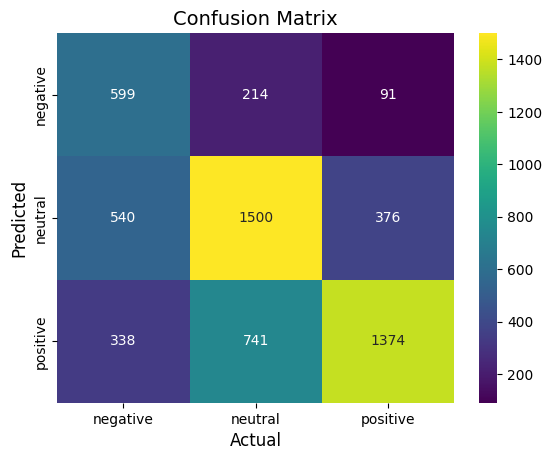

In [341]:
# show confusion matrix in a heatmap
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=labels,
            yticklabels=labels,
            cmap='viridis')

plt.ylabel('Predicted', fontsize=12)
plt.xlabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [345]:
# view balance of test set targets
print(y_test.value_counts())
print("\nRows:", y_test.shape[0])

sentiment
positive    2453
neutral     2416
negative     904
Name: count, dtype: int64

Rows: 5773


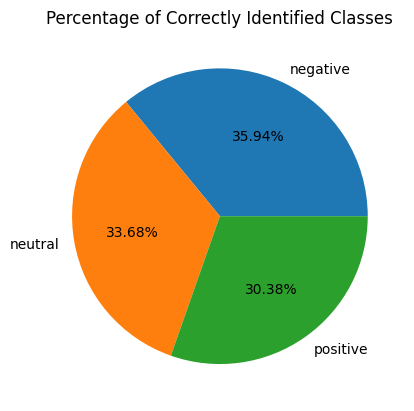

In [343]:
# calculate percentage of correctly identified sentiments
percent = cm.diagonal() / cm.sum(axis=1)

# show percentages in a pie chart
plt.pie(percent, labels=labels, autopct="%1.2f%%")
plt.title("Percentage of Correctly Identified Classes")
plt.show()

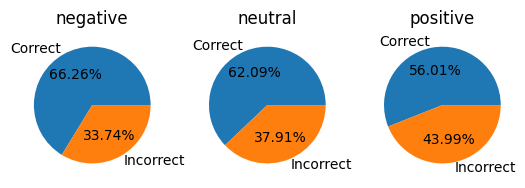

In [344]:
# calculate percentage of correctly identified sentiments per sentiment
percent_correct = [np.sum(cm[i, i]) / np.sum(cm[i, :]) for i in range(len(cm))]
percent_incorrect = [1 - percent_correct[i] for i in range(len(cm))]

# show percentages in pie charts
fig, axs = plt.subplots(1, len(cm))
for i in range(len(cm)):
    axs[i].pie([percent_correct[i], percent_incorrect[i]], labels=["Correct", "Incorrect"], autopct="%1.2f%%")
    axs[i].set_title(labels[i])
plt.show()

# Hyperparameter Tuning

In [364]:
# provide parameter dictionary
parameters = {
    "C": [1, 5, 10],                                    # regularization parameter, higher = more sensitive to misclassifications
    "kernel": ["linear", "rbf", "poly", "sigmoid"],     # kernel type
    "gamma": ["scale", "auto", 0.0, 0.5],               # kernel coefficient, only important if rbf/poly/sigmoid, higher = more sensitive to local variations in the data
    "degree": [3, 4, 5],                                # only important if poly
    "coef0": [0, 0.5, 1],                               # only important if poly/sigmoid
    "decision_function_shape": ["ovo", "ovr"]           # one-vs-one or one-vs-rest
}

# create blank model
model_tuner = SVC(random_state=77)

# perform grid search on f1_macro metric
model_tuner = GridSearchCV(
    model_tuner,
    parameters,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# fit the model
tune_results = model_tuner.fit(x_train, y_train)

# get the best hyperparameters
print("Best Params: ", tune_results.best_params_)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


KeyboardInterrupt: 

In [348]:
# Time: 4m 39.0s
# Best Params:  {'C': 1, 'kernel': 'rbf'}

# Time: 1m 23.0s
# Best Params:  {'gamma': 'scale', 'max_iter': -1}

# Time: 3m 3.9s
# Best Params:  {'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 'scale'}

In [360]:
# create new model with best hyperparameters
tuned_model = SVC(random_state=77,
    decision_function_shape='ovo'
)

# fit the tuned model
tuned_model.fit(x_train, y_train)

# predict
predictions = tuned_model.predict(x_test)

# check metric scores
print("Accuracy:", balanced_accuracy_score(y_test, predictions))
print("Precision:", precision_score(y_test, predictions, average="macro"))
print("Recall:", recall_score(y_test, predictions, average="macro"))
print("F1 Score:", f1_score(y_test, predictions, average="macro"))

Accuracy: 0.6145339997094929
Precision: 0.5876277573039532
Recall: 0.6145339997094929
F1 Score: 0.5863342122333552


In [361]:
# SCORE TO BEAT:
# Accuracy: 0.6145339997094929
# Precision: 0.5876277573039532
# Recall: 0.6145339997094929
# F1 Score: 0.5863342122333552

# RESULTING SCORE:


In [362]:
# generate confusion matrix
labels = np.unique(predictions)
cm = confusion_matrix(y_test, predictions, labels=labels)
cm

array([[ 599,  214,   91],
       [ 540, 1500,  376],
       [ 338,  741, 1374]], dtype=int64)

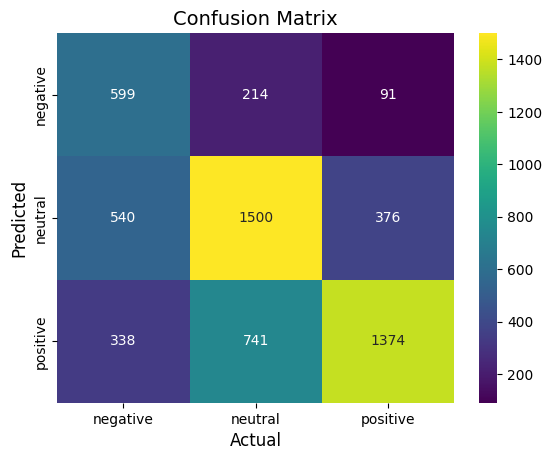

In [363]:
# show confusion matrix in a heatmap
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=labels,
            yticklabels=labels,
            cmap='viridis')

plt.ylabel('Predicted', fontsize=12)
plt.xlabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.show()